In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("all_data.csv")

drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","ROT"
]

def show_correlation_matrix(dataframe, taille_figure=(6, 4), cmap="coolwarm"):
    plt.figure(figsize=taille_figure)
    sns.heatmap(dataframe.corr(), cmap=cmap, center=0)
    plt.title("Correlation matrix")
    plt.show()

def show_target_correlation(df, variable="SOG", taille_figure=(6, 4)):
    corr_with_vmg = df.corr()[variable].sort_values(ascending=False)
    #print(f"Correlation with {variable} :")
    # print(corr_with_vmg)
    
    plt.figure(figsize=taille_figure)
    sns.heatmap(corr_with_vmg.to_frame(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation with {variable}")
    plt.show()

def compute_anova(df, target="SOG"):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)
    df_no_missing = df_copy.dropna(subset=cols)
    formula_no_missing = f"{target} ~ " + " + ".join(
        list(df_no_missing.columns.drop(target)))
    model_no_missing = smf.ols(formula=formula_no_missing, data=df_no_missing).fit()
    anova_no_missing = sm.stats.anova_lm(model_no_missing, typ=2)
    return anova_no_missing.sort_values("F", ascending=False)

def linear_regression(df, target="SOG", degree=1, top_coefs=30):
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)

    df_clean = df_copy.dropna(subset=cols)
    if df_clean[target].isna().any():
        df_clean = df_clean.dropna(subset=[target])

    X = df_clean[cols]
    y = df_clean[target]

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)

    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )

    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # Affichage de la performance
    print(f"R²: {r2_score(y, y_pred):.3f}")
    print(f"Used samples: {len(X)}")

    # Coefficients
    coefs = model.named_steps['linearregression'].coef_
    intercept = model.named_steps['linearregression'].intercept_

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs
    }).sort_values('coefficient', key=abs, ascending=False)

    # Formule affichée
    print("\n Formula :")
    terms = [f"{coef:.3f} * {feat}" for feat, coef in zip(feature_names, coefs)]
    equation = " +\n  ".join(terms)
    print(f"{target} ≈ {intercept:.3f} +\n  {equation}")

    return coef_df.head(top_coefs)


def t_test(df1, df2, target="SOG"):
    t_stat, p_value = stats.ttest_ind(df1[target].dropna(), df2[target].dropna())
    print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.15f}")
    
    # If p-value is less than 0.05, the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant, keeping data split.")
    else:
        print("The difference is not statistically significant, keeping data combined.")

def full_analysis(df_numeric, target_variable="SOG"):
    # Display the correlation matrix
    # print("Correlation matrix:")
    #show_correlation_matrix(df_numeric)
    
    # Display correlation with the target variable
    print(f"\nCorrelation with {target_variable}:")
    show_target_correlation(df_numeric, variable=target_variable)
    
    # Compute and display ANOVA results
    print("\nANOVA:")
    anova_results = compute_anova(df_numeric)
    display(anova_results)
    
    # Apply and display polynomial regression results
    print("\nPolynomial fit:")
    regression_results = linear_regression(df_numeric)
    display(regression_results)




## I. All together

In [2]:


df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)
df_numeric.dropna(subset=["SOG"], inplace=True)

print(f"Variables utilisées:", df_numeric.columns.tolist())
print(f"Number of rows after filtering: {len(df_numeric)}")


Variables utilisées: ['Heel_Abs', 'Line_C', 'Side_lines', 'Total_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight']
Number of rows after filtering: 80131



Correlation with SOG:


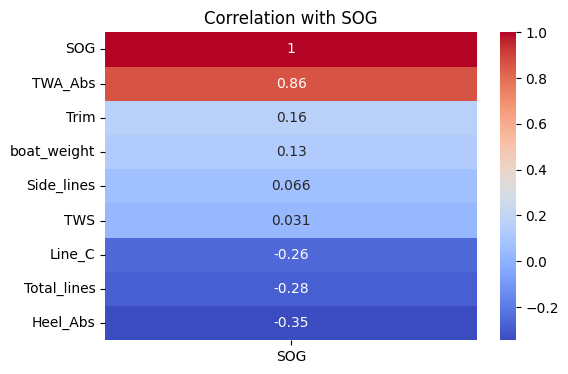


ANOVA:


,sum_sq,df,F,PR(>F)
TWA_Abs,240958.201064,1.0,201044.632404,0.000000e+00
Total_lines,6201.778597,1.0,5174.483760,0.000000e+00
TWS,4220.748490,1.0,3521.601775,0.000000e+00
boat_weight,3156.452157,1.0,2633.601018,0.000000e+00
Trim,1491.748633,1.0,1244.647637,2.903433e-270
Line_C,624.350096,1.0,520.929502,7.000526e-115
Heel_Abs,565.553799,1.0,471.872529,2.778946e-104
Side_lines,136.087012,1.0,113.544852,1.717927e-26
Residual,83821.654457,69937.0,NaN,NaN



Polynomial fit:
R²: 0.811
Used samples: 69946

 Formula :
SOG ≈ 23.994 +
  0.113 * Heel_Abs +
  -0.432 * Line_C +
  -0.195 * Side_lines +
  0.589 * Total_lines +
  -0.160 * Trim +
  2.468 * TWA_Abs +
  0.253 * TWS +
  0.237 * boat_weight


,feature,coefficient
5,TWA_Abs,2.467529
3,Total_lines,0.588746
1,Line_C,-0.432368
6,TWS,0.253341
7,boat_weight,0.237189
2,Side_lines,-0.194544
4,Trim,-0.159996
0,Heel_Abs,0.112829


In [3]:
full_analysis(df_numeric)

## II Upwind:

### II.1. All upwind data

In [4]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 48787



Correlation with SOG:


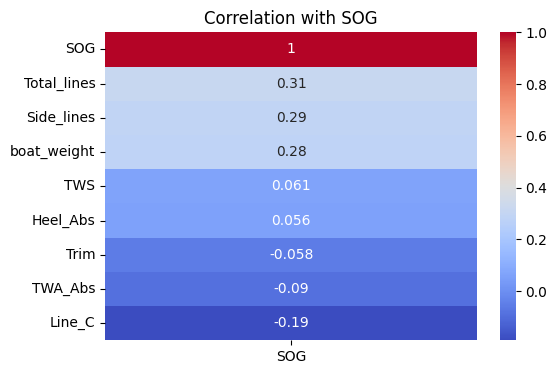


ANOVA:


,sum_sq,df,F,PR(>F)
Total_lines,2353.197105,1.0,2077.448714,0.000000e+00
boat_weight,2278.278958,1.0,2011.309500,0.000000e+00
Trim,625.059659,1.0,551.814968,2.942378e-121
TWS,425.309878,1.0,375.471930,2.728176e-83
Line_C,139.601561,1.0,123.243006,1.349094e-28
Heel_Abs,60.916598,1.0,53.778371,2.283655e-13
TWA_Abs,50.378033,1.0,44.474719,2.607682e-11
Side_lines,0.789659,1.0,0.697127,4.037555e-01
Residual,48808.381820,43089.0,NaN,NaN



Polynomial fit:
R²: 0.211
Used samples: 43098

 Formula :
SOG ≈ 22.278 +
  0.040 * Heel_Abs +
  -0.262 * Line_C +
  -0.020 * Side_lines +
  0.385 * Total_lines +
  -0.125 * Trim +
  0.038 * TWA_Abs +
  0.107 * TWS +
  0.253 * boat_weight


,feature,coefficient
3,Total_lines,0.385467
1,Line_C,-0.262141
7,boat_weight,0.253406
4,Trim,-0.125098
6,TWS,0.107137
0,Heel_Abs,0.040192
5,TWA_Abs,0.037884
2,Side_lines,-0.019505


In [5]:
full_analysis(df_numeric_upwind)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [6]:
gian_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Gian Stragiotti") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 24390



Correlation with SOG:


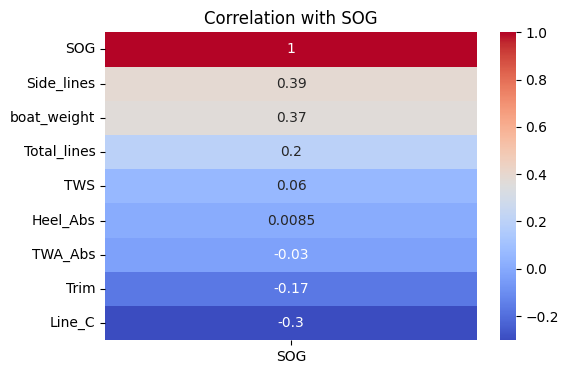


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,698.526004,1.0,714.373955,3.909729e-155
Trim,603.236041,1.0,616.922082,1.661208e-134
boat_weight,151.255598,1.0,154.687241,2.100608e-35
Total_lines,119.463087,1.0,122.173430,2.471030e-28
TWA_Abs,85.266198,1.0,87.200692,1.061947e-20
Side_lines,23.783048,1.0,24.322631,8.201348e-07
Heel_Abs,7.983076,1.0,8.164193,4.276173e-03
Line_C,0.133261,1.0,0.136285,7.120061e-01
Residual,23767.764005,24307.0,NaN,NaN



Polynomial fit:
R²: 0.253
Used samples: 24316

 Formula :
SOG ≈ 22.438 +
  -0.020 * Heel_Abs +
  -0.029 * Line_C +
  0.370 * Side_lines +
  0.286 * Total_lines +
  -0.160 * Trim +
  0.064 * TWA_Abs +
  0.211 * TWS +
  0.122 * boat_weight


,feature,coefficient
2,Side_lines,0.370315
3,Total_lines,0.286276
6,TWS,0.210825
4,Trim,-0.159726
7,boat_weight,0.121940
5,TWA_Abs,0.064459
1,Line_C,-0.029165
0,Heel_Abs,-0.019830


In [7]:
full_analysis(df_numeric_gian_upwind)

#### II.2.2. Upwind: Karl

In [8]:
karl_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Karl Maeder") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")

Number of rows after filtering: 24397



Correlation with SOG:


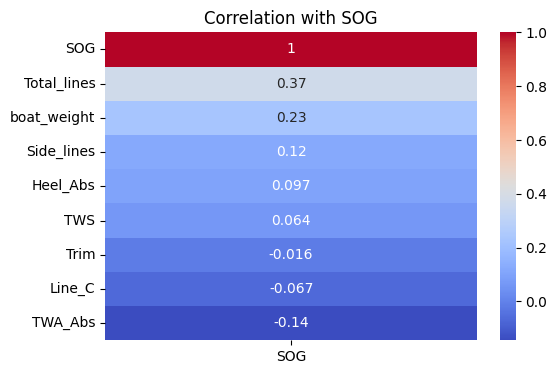


ANOVA:


,sum_sq,df,F,PR(>F)
Total_lines,2252.477090,1.0,1863.796179,0.000000e+00
boat_weight,1489.071108,1.0,1232.121318,1.706765e-261
Line_C,348.209804,1.0,288.123730,3.836604e-64
Heel_Abs,294.491410,1.0,243.674827,1.369983e-54
Side_lines,264.388035,1.0,218.766003,3.182157e-49
TWS,188.475873,1.0,155.953023,1.201191e-35
Trim,40.713894,1.0,33.688422,6.572658e-09
TWA_Abs,2.427988,1.0,2.009021,1.563828e-01
Residual,22687.970330,18773.0,NaN,NaN



Polynomial fit:
R²: 0.208
Used samples: 18782

 Formula :
SOG ≈ 22.072 +
  0.134 * Heel_Abs +
  -0.483 * Line_C +
  -0.420 * Side_lines +
  0.505 * Total_lines +
  -0.048 * Trim +
  -0.014 * TWA_Abs +
  0.117 * TWS +
  0.300 * boat_weight


,feature,coefficient
3,Total_lines,0.504666
1,Line_C,-0.483407
2,Side_lines,-0.419928
7,boat_weight,0.300262
0,Heel_Abs,0.133871
6,TWS,0.116662
4,Trim,-0.048060
5,TWA_Abs,-0.013587


In [9]:
full_analysis(df_numeric_karl_upwind)

#### II.2.3. Upwind: Karl vs Gian t_test

In [10]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: 31.779, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [11]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 24391



Correlation with SOG:


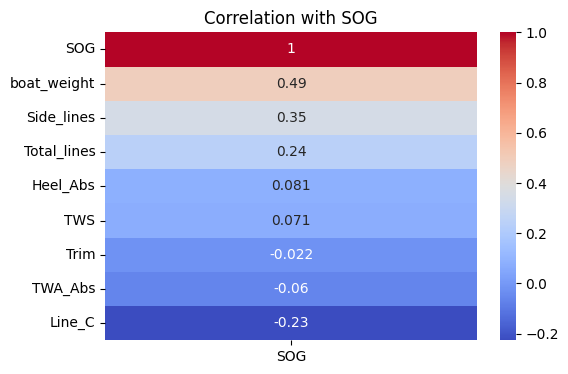


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,5220.034783,1.0,5033.818435,0.000000e+00
Trim,217.512348,1.0,209.752945,2.628916e-47
TWA_Abs,209.993793,1.0,202.502602,9.690911e-46
Heel_Abs,98.261722,1.0,94.756393,2.400553e-22
Side_lines,20.841999,1.0,20.098495,7.394344e-06
Total_lines,15.833332,1.0,15.268503,9.355086e-05
Line_C,2.600622,1.0,2.507849,1.132955e-01
TWS,1.054175,1.0,1.016569,3.133458e-01
Residual,21787.224196,21010.0,NaN,NaN



Polynomial fit:
R²: 0.326
Used samples: 21019

 Formula :
SOG ≈ 22.417 +
  0.073 * Heel_Abs +
  0.133 * Line_C +
  0.368 * Side_lines +
  0.119 * Total_lines +
  -0.106 * Trim +
  -0.109 * TWA_Abs +
  0.008 * TWS +
  0.545 * boat_weight


,feature,coefficient
7,boat_weight,0.545488
2,Side_lines,0.368134
1,Line_C,0.133326
3,Total_lines,0.119049
5,TWA_Abs,-0.109487
4,Trim,-0.105970
0,Heel_Abs,0.073325
6,TWS,0.007570


In [12]:
full_analysis(df_numeric_master_upwind)

#### II.3.2 Slave

In [13]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 24396



Correlation with SOG:


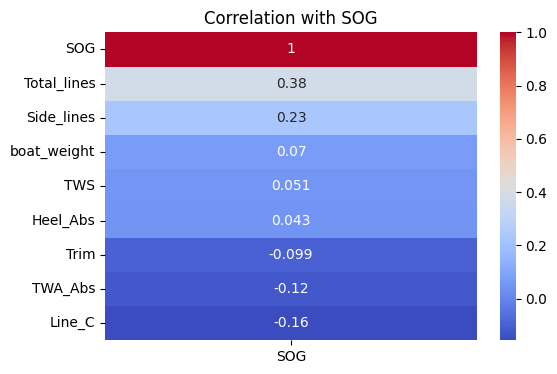


ANOVA:


,sum_sq,df,F,PR(>F)
Total_lines,2690.187077,1.0,2603.367399,0.000000e+00
Trim,310.113460,1.0,300.105252,8.646877e-67
TWS,228.568806,1.0,221.192267,8.661230e-50
Line_C,191.641633,1.0,185.456835,4.614673e-42
Side_lines,32.590531,1.0,31.538746,1.978527e-08
TWA_Abs,24.802225,1.0,24.001790,9.692771e-07
boat_weight,3.348174,1.0,3.240119,7.186905e-02
Heel_Abs,0.574341,1.0,0.555805,4.559632e-01
Residual,22806.012245,22070.0,NaN,NaN



Polynomial fit:
R²: 0.207
Used samples: 22079

 Formula :
SOG ≈ 22.146 +
  -0.006 * Heel_Abs +
  -0.396 * Line_C +
  -0.162 * Side_lines +
  0.534 * Total_lines +
  -0.123 * Trim +
  0.040 * TWA_Abs +
  0.113 * TWS +
  -0.014 * boat_weight


,feature,coefficient
3,Total_lines,0.534483
1,Line_C,-0.396436
2,Side_lines,-0.161820
4,Trim,-0.123100
6,TWS,0.113177
5,TWA_Abs,0.039867
7,boat_weight,-0.014298
0,Heel_Abs,-0.005501


In [14]:
full_analysis(df_numeric_slave_upwind)

#### III.3.3. Upwind: Master vs Slave t_test

In [15]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 16.509, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [16]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 31344



Correlation with SOG:


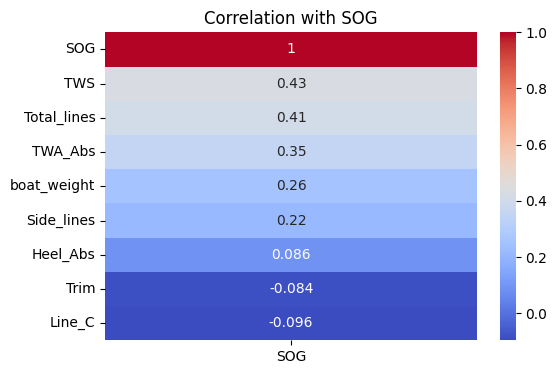


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,3775.035079,1.0,3368.647936,0.000000e+00
Total_lines,2555.103325,1.0,2280.043328,0.000000e+00
TWA_Abs,1518.758713,1.0,1355.262481,1.754042e-289
boat_weight,972.139731,1.0,867.487700,1.113999e-187
Trim,489.713730,1.0,436.995448,2.858249e-96
Heel_Abs,460.450003,1.0,410.881997,1.125895e-90
Line_C,322.218759,1.0,287.531516,3.705212e-64
Side_lines,196.654441,1.0,175.484350,6.264480e-40
Residual,30076.804816,26839.0,NaN,NaN



Polynomial fit:
R²: 0.419
Used samples: 26848

 Formula :
SOG ≈ 26.749 +
  0.169 * Heel_Abs +
  -0.509 * Line_C +
  -0.384 * Side_lines +
  0.629 * Total_lines +
  -0.164 * Trim +
  0.295 * TWA_Abs +
  0.443 * TWS +
  0.221 * boat_weight


,feature,coefficient
3,Total_lines,0.628929
1,Line_C,-0.508525
6,TWS,0.442808
2,Side_lines,-0.383687
5,TWA_Abs,0.294523
7,boat_weight,0.220712
0,Heel_Abs,0.169205
4,Trim,-0.163864


In [17]:

full_analysis(df_numeric_downwind)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [18]:
gian_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Gian Stragiotti") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 15667



Correlation with SOG:


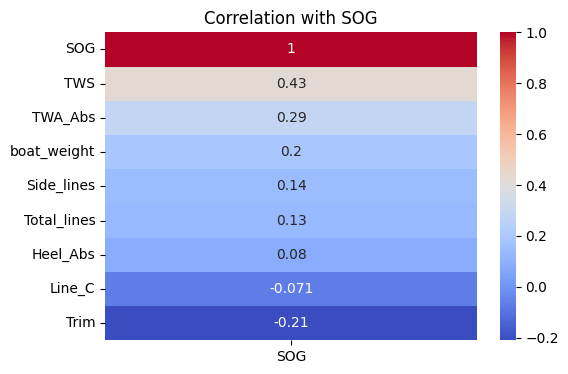


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,4372.528648,1.0,4128.919187,0.000000e+00
TWA_Abs,1126.895653,1.0,1064.112201,7.428469e-226
Trim,558.534495,1.0,527.416509,8.185984e-115
Heel_Abs,477.556933,1.0,450.950501,1.110798e-98
boat_weight,120.840190,1.0,114.107744,1.524415e-26
Total_lines,13.907040,1.0,13.132228,2.911815e-04
Side_lines,9.587378,1.0,9.053230,2.626495e-03
Line_C,0.059054,1.0,0.055764,8.133247e-01
Residual,16525.707201,15605.0,NaN,NaN



Polynomial fit:
R²: 0.382
Used samples: 15614

 Formula :
SOG ≈ 26.918 +
  0.227 * Heel_Abs +
  0.034 * Line_C +
  0.412 * Side_lines +
  0.248 * Total_lines +
  -0.227 * Trim +
  0.331 * TWA_Abs +
  0.654 * TWS +
  -0.153 * boat_weight


,feature,coefficient
6,TWS,0.654198
2,Side_lines,0.412184
5,TWA_Abs,0.330809
3,Total_lines,0.248177
0,Heel_Abs,0.227125
4,Trim,-0.226502
7,boat_weight,-0.153127
1,Line_C,0.034477


In [19]:

full_analysis(df_numeric_gian_downwind)

#### III.2.2. Downwind: Karl

In [20]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 15677



Correlation with SOG:


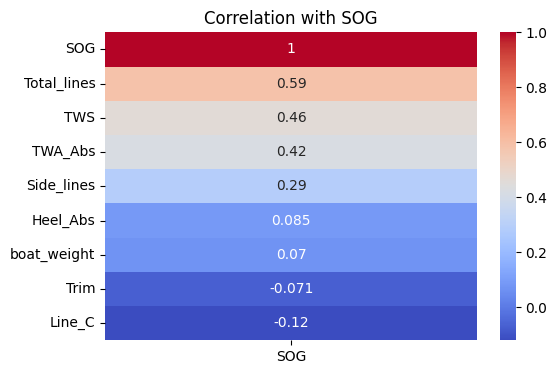


ANOVA:


,sum_sq,df,F,PR(>F)
Total_lines,2382.987857,1.0,2233.031894,0.000000e+00
TWA_Abs,705.124909,1.0,660.753015,1.222369e-141
boat_weight,497.999185,1.0,466.661238,1.954038e-101
TWS,448.733951,1.0,420.496152,9.039459e-92
Line_C,433.971778,1.0,406.662929,7.247991e-89
Side_lines,305.108123,1.0,285.908368,2.349896e-63
Heel_Abs,75.722178,1.0,70.957155,4.094761e-17
Trim,61.811076,1.0,57.921447,2.946368e-14
Residual,11978.798317,11225.0,NaN,NaN



Polynomial fit:
R²: 0.500
Used samples: 11234

 Formula :
SOG ≈ 26.514 +
  0.107 * Heel_Abs +
  -0.672 * Line_C +
  -0.527 * Side_lines +
  0.804 * Total_lines +
  -0.091 * Trim +
  0.328 * TWA_Abs +
  0.276 * TWS +
  0.227 * boat_weight


,feature,coefficient
3,Total_lines,0.803726
1,Line_C,-0.671555
2,Side_lines,-0.526955
5,TWA_Abs,0.327953
6,TWS,0.275820
7,boat_weight,0.226923
0,Heel_Abs,0.107072
4,Trim,-0.090641


In [21]:
full_analysis(df_numeric_karl_downwind)

#### III.2.3. Downwind: Karl vs Gian t_test

In [22]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -38.976, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [23]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 15670



Correlation with SOG:


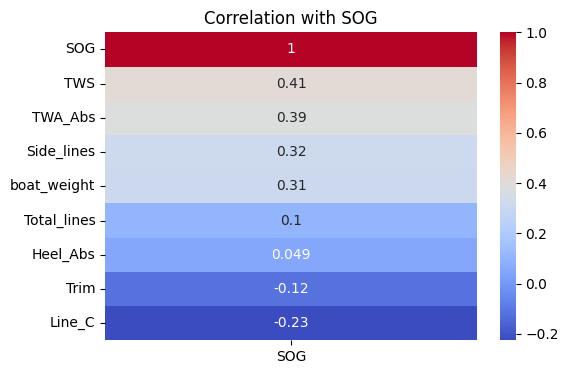


ANOVA:


,sum_sq,df,F,PR(>F)
TWA_Abs,2321.107535,1.0,2229.846956,0.000000e+00
TWS,2173.632278,1.0,2088.170084,0.000000e+00
boat_weight,1135.059349,1.0,1090.431441,7.190127e-230
Trim,314.334335,1.0,301.975436,6.736798e-67
Heel_Abs,244.313153,1.0,234.707324,1.580553e-52
Total_lines,11.680863,1.0,11.221598,8.107652e-04
Line_C,2.081134,1.0,1.999309,1.573945e-01
Side_lines,0.132006,1.0,0.126816,7.217622e-01
Residual,13790.198718,13248.0,NaN,NaN



Polynomial fit:
R²: 0.453
Used samples: 13257

 Formula :
SOG ≈ 26.717 +
  0.175 * Heel_Abs +
  -0.210 * Line_C +
  0.051 * Side_lines +
  0.230 * Total_lines +
  -0.188 * Trim +
  0.476 * TWA_Abs +
  0.460 * TWS +
  0.339 * boat_weight


,feature,coefficient
5,TWA_Abs,0.475636
6,TWS,0.460416
7,boat_weight,0.338600
3,Total_lines,0.229657
1,Line_C,-0.209759
4,Trim,-0.187898
0,Heel_Abs,0.175078
2,Side_lines,0.051449


In [24]:
full_analysis(df_numeric_master_downwind)

#### III.3.2 Downwind Slave

In [25]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 15674



Correlation with SOG:


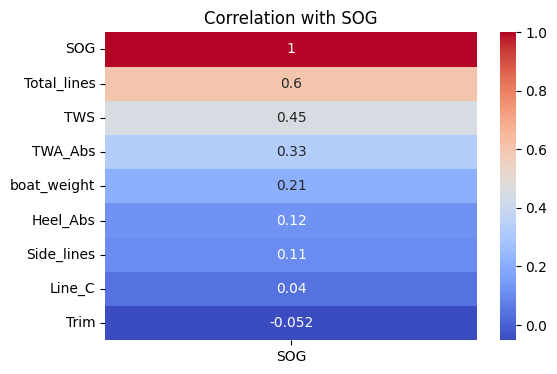


ANOVA:


,sum_sq,df,F,PR(>F)
Total_lines,4125.082223,1.0,4244.438089,0.000000e+00
TWS,1349.082391,1.0,1388.116982,2.258960e-289
Side_lines,730.524329,1.0,751.661450,4.077095e-161
Line_C,702.499263,1.0,722.825502,3.611148e-155
Trim,306.670496,1.0,315.543755,8.325116e-70
Heel_Abs,250.435544,1.0,257.681691,1.854004e-57
boat_weight,34.369026,1.0,35.363466,2.802898e-09
TWA_Abs,11.987885,1.0,12.334745,4.460485e-04
Residual,13200.066906,13582.0,NaN,NaN



Polynomial fit:
R²: 0.502
Used samples: 13591

 Formula :
SOG ≈ 26.780 +
  0.177 * Heel_Abs +
  -0.943 * Line_C +
  -0.883 * Side_lines +
  1.101 * Total_lines +
  -0.182 * Trim +
  0.041 * TWA_Abs +
  0.394 * TWS +
  0.060 * boat_weight


,feature,coefficient
3,Total_lines,1.100856
1,Line_C,-0.942517
2,Side_lines,-0.882542
6,TWS,0.394109
4,Trim,-0.182458
0,Heel_Abs,0.177179
7,boat_weight,0.059977
5,TWA_Abs,0.041205


In [26]:
full_analysis(df_numeric_slave_downwind)

#### III.3.3. Downwind: Master vs Slave t_test

In [27]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: 0.953, p-value: 0.340575073568009
The difference is not statistically significant, keeping data combined.
